#Deep Learning Assignmenet
Implementation file by - M25MAC004, M25MAC008, M25MAC014, M25MAC016

#Dataset Selection - Fashion-MNIST Dataset is used for this assignment

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import time

In [21]:
# For Reproducibility
def set_seed(seed=56):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(56)


In [22]:
# ───Checing device for GPU  ──────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [23]:
# ───Loading Dataset ~downloading directly in the code file─────────────────────────────────────────────────────────
transform = transforms.Compose([
    transforms.ToTensor(),                          # [0,1], shape (1,28,28)
    transforms.Normalize((0.2860,), (0.3530,)),     # Fashion-MNIST mean/std
])

Train_set = datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)
Test_set   = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)



#Details of the Training data set

In [24]:
print(f"Dataset Name: Fashion-MNIST - Details of the Train data")
print(f"Number of training samples: {len(Train_set)} ")
print(f"Image dimensions: {Train_set[0][0].shape} (C, H, W) ")
print(f"Number of classes: {len(Train_set.classes)}")
print(f"Classes: {Train_set.classes} ")

Dataset Name: Fashion-MNIST - Details of the Train data
Number of training samples: 60000 
Image dimensions: torch.Size([1, 28, 28]) (C, H, W) 
Number of classes: 10
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 


#Details of the Test data set

In [25]:
print(f"Dataset Name: Fashion-MNIST -Details of the Test data")
print(f"Number of training samples: {len(Test_set)} ")
print(f"Image dimensions: {Test_set[0][0].shape} (C, H, W) ")
print(f"Number of classes: {len(Test_set.classes)}")
print(f"Classes: {Test_set.classes} ")

Dataset Name: Fashion-MNIST -Details of the Test data
Number of training samples: 10000 
Image dimensions: torch.Size([1, 28, 28]) (C, H, W) 
Number of classes: 10
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 


#Train-Test split
using 50,000 Samples fro training and all 10000 samples for testing split.

In [26]:
# Dataset split ~ 50 000 train / 10 000 val split
train_set, val_set = random_split(Train_set, [50000, 10000],
                                  generator=torch.Generator().manual_seed(56))

BATCH_SIZE = 128
Training_data = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
Validation_data   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
Testing_data  = DataLoader(Test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


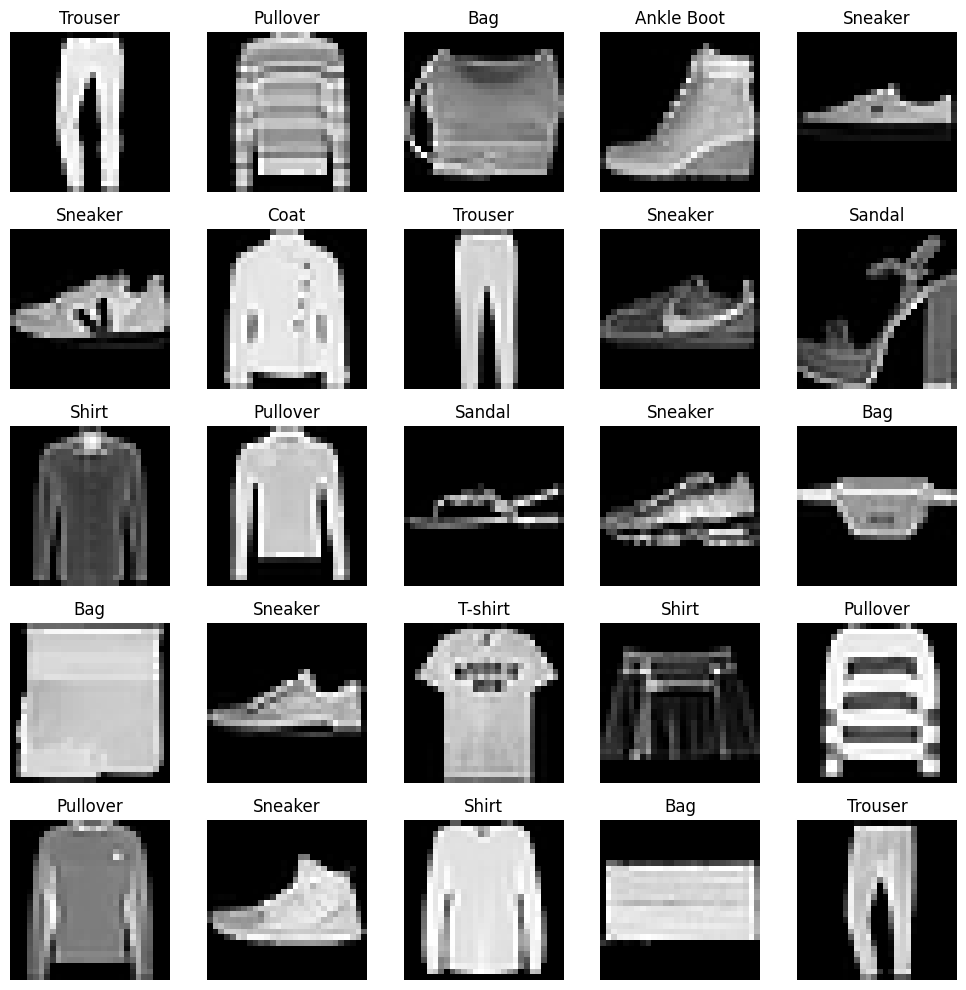

In [27]:
import matplotlib.pyplot as plt
# Creating the visualization grid
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5

#defining lablesas given in the original dataset for the plot lables
labels_map = {
    0: "T-shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"
}
for i in range(1, cols * rows + 1):
    # Select a random image from the dataset
    sample_idx = torch.randint(len(Train_set), size=(1,)).item()
    img, label = Train_set[sample_idx]

    # Plotting
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # Squeeze the tensor (1, 28, 28) to (28, 28) for grayscale display
    plt.imshow(img.squeeze(), cmap="gray")

plt.tight_layout()
plt.show()

#Building a Custom CNN model as the ResNET model is clearly overfillting in our experiment.

In [28]:
import torch.nn as nn
import torchvision.models

def train_prep_img(model, device):
    if isinstance(model, torchvision.models.resnet.ResNet):
        # Modify first layer for 1-channel input
        original_conv1 = model.conv1
        model.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv1.out_channels,
            kernel_size=original_conv1.kernel_size,
            stride=original_conv1.stride,
            padding=original_conv1.padding,
            bias=original_conv1.bias is not None
        )
        # Remove maxpool for small images
        model.maxpool = nn.Identity()
        # Modify final layer for 10 classes
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 10)
    elif isinstance(model, torchvision.models.vgg.VGG):
        # Modify first layer for 1-channel input
        original_conv0 = model.features[0]
        model.features[0] = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv0.out_channels,
            kernel_size=original_conv0.kernel_size,
            stride=original_conv0.stride,
            padding=original_conv0.padding,
            bias=original_conv0.bias is not None
        )

        # Adapt VGG features for smaller images by reducing pooling aggressiveness.
        # For 28x28 images, the standard VGG features module with 5 MaxPool2d layers
        # will typically cause the spatial dimensions to collapse to 0x0. We need to
        # ensure the output feature map size from `features` is not less than 1x1.

        # Find all MaxPool2d layers and identify the indices of the ones to remove.
        pool_indices_to_remove = []
        for i, m in enumerate(model.features.children()):
            if isinstance(m, nn.MaxPool2d):
                pool_indices_to_remove.append(i)

        # Replace the last two MaxPool2d layers with Identity to prevent dimension collapse.
        # This allows 3 pooling layers for 28x28 -> 3x3 output, then avgpool to 1x1.
        if len(pool_indices_to_remove) >= 2:
            model.features[pool_indices_to_remove[-1]] = nn.Identity()
            model.features[pool_indices_to_remove[-2]] = nn.Identity()
        elif len(pool_indices_to_remove) == 1: # Fallback if there's only one pooling layer left and it's problematic
             model.features[pool_indices_to_remove[-1]] = nn.Identity()

        # Replace default AdaptiveAvgPool2d((7,7)) with (1,1) to handle varying
        # output sizes from modified features block and prepare for classifier.
        model.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Reconstruct the classifier block to match the new input features.
        # The last convolutional layer in VGG features block typically outputs 512 channels.
        # After AdaptiveAvgPool2d((1,1)), the input to the classifier will be 512 * 1 * 1.
        num_ftrs = 512 * 1 * 1 # Assuming 512 output channels from the features block after avgpool(1,1)

        # Build a new, simpler classifier for Fashion-MNIST (10 classes).
        model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 256), # Reduced hidden layer size for efficiency
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(256, 10), # Output layer for 10 classes
        )

    else:
        raise ValueError("Unsupported model type for train_prep_img")

    return model.to(device)

In [29]:
from torchvision.models import resnet18
from torchvision.models import vgg16
from torchvision.models import vgg19

Model_ResNet = resnet18(weights=None)  # No pretrained allowed
Model_ResNet_final = train_prep_img(Model_ResNet, device)

Model_Vgg16 = vgg16(weights=None)  # No pretrained allowed
Model_Vgg16_final= train_prep_img(Model_Vgg16, device)

Model_Vgg19 = vgg19(weights=None)  # No pretrained allowed
Model_Vgg19_final=train_prep_img(Model_Vgg19, device)

In [30]:
def run_training_pipeline(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    best_val_acc = 0.0

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Evaluation phase
        model.eval()
        running_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_acc = 100. * correct / total

        scheduler.step()

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"best_{model.__class__.__name__.lower()}_fmnist.pth")
            print("Saved Best Model")

        print(f"Epoch {epoch+1}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Final test evaluation
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total

    print(f"\nFinal Test Loss: {test_loss:.4f}")
    print(f"Final Test Accuracy: {test_acc:.2f}%")

    return train_losses, train_accs, val_losses, val_accs, test_loss, test_acc

#Creating a function for plotting

In [31]:
def plot_training_curves(train_losses, train_accs, val_losses, val_accs, test_acc, model_name):
    epochs_range = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy plot
    axes[0].plot(epochs_range, train_accs, 'o-', label='Training Accuracy',
                 color='#2563eb', markersize=4, linewidth=1.5)
    axes[0].plot(epochs_range, val_accs,   's-', label='Validation Accuracy',
                 color='#dc2626', markersize=4, linewidth=1.5)
    axes[0].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    # Optional: Set a reasonable y-limit for accuracy
    # axes[0].set_ylim([min(min(train_accs), min(val_accs)) * 0.9, 1.0])

    # Loss plot
    axes[1].plot(epochs_range, train_losses, 'o-', label='Training Loss',
                 color='#2563eb', markersize=4, linewidth=1.5)
    axes[1].plot(epochs_range, val_losses,   's-', label='Validation Loss',
                 color='#dc2626', markersize=4, linewidth=1.5)
    axes[1].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss (Cross-Entropy)', fontsize=12)
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    # Main title for the figure
    fig.suptitle(f'{model_name} on Fashion-MNIST  —  Test Accuracy: {test_acc:.2f}%',
                 fontsize=15, fontweight='bold', y=1.02)

    plt.tight_layout()

    # Save the figure
    filename = f'{model_name.lower().replace(' ', '_')}_training_curves.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"Saved {filename}")

    plt.show()

print("Function 'plot_training_curves' defined.")

Function 'plot_training_curves' defined.


#Running VGG16 model


Saved Best Model
Epoch 1:
Train Loss: 1.5639, Train Acc: 38.45%
Val Loss: 0.6384, Val Acc: 75.86%
Saved Best Model
Epoch 2:
Train Loss: 0.5811, Train Acc: 78.17%
Val Loss: 0.4313, Val Acc: 83.77%
Saved Best Model
Epoch 3:
Train Loss: 0.4235, Train Acc: 84.98%
Val Loss: 0.3443, Val Acc: 87.36%
Saved Best Model
Epoch 4:
Train Loss: 0.3476, Train Acc: 87.94%
Val Loss: 0.3229, Val Acc: 88.27%
Saved Best Model
Epoch 5:
Train Loss: 0.2956, Train Acc: 89.68%
Val Loss: 0.2939, Val Acc: 89.14%
Saved Best Model
Epoch 6:
Train Loss: 0.2646, Train Acc: 90.72%
Val Loss: 0.2531, Val Acc: 91.15%
Saved Best Model
Epoch 7:
Train Loss: 0.2412, Train Acc: 91.55%
Val Loss: 0.2389, Val Acc: 91.43%
Saved Best Model
Epoch 8:
Train Loss: 0.2200, Train Acc: 92.39%
Val Loss: 0.2326, Val Acc: 91.75%
Saved Best Model
Epoch 9:
Train Loss: 0.1989, Train Acc: 92.98%
Val Loss: 0.2239, Val Acc: 92.03%
Epoch 10:
Train Loss: 0.1841, Train Acc: 93.62%
Val Loss: 0.2296, Val Acc: 91.98%
Saved Best Model
Epoch 11:
Train Los

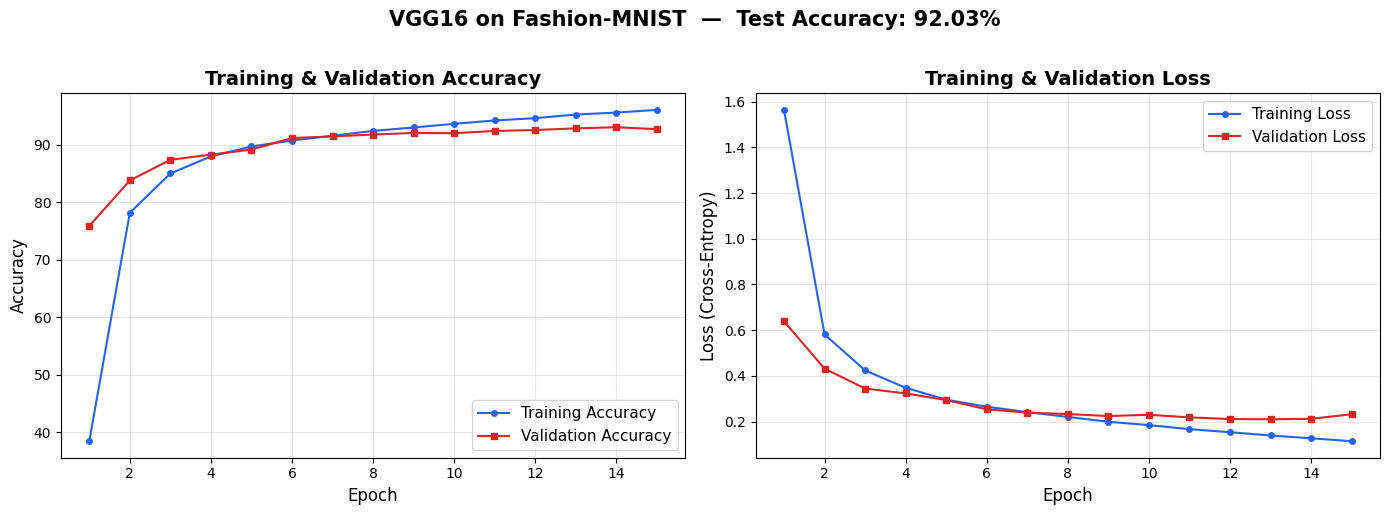

In [32]:
criterion = nn.CrossEntropyLoss()

optimizer_Vgg16 = optim.SGD(
    Model_Vgg16_final.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=5e-4
)

scheduler_Vgg16 = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_Vgg16,
    T_max=50
)

train_losses_vgg16, train_accs_vgg16, val_losses_vgg16, val_accs_vgg16, test_loss_vgg16, test_acc_vgg16 = run_training_pipeline(Model_Vgg16_final, Training_data, Validation_data, Testing_data, criterion, optimizer_Vgg16, scheduler_Vgg16, device, 15)

plot_training_curves(train_losses_vgg16, train_accs_vgg16, val_losses_vgg16, val_accs_vgg16, test_acc_vgg16, 'VGG16')

#Running VGG19 model



Saved Best Model
Epoch 1:
Train Loss: 1.8947, Train Acc: 25.98%
Val Loss: 0.9576, Val Acc: 60.85%
Saved Best Model
Epoch 2:
Train Loss: 0.7275, Train Acc: 72.66%
Val Loss: 0.5761, Val Acc: 77.14%
Saved Best Model
Epoch 3:
Train Loss: 0.5121, Train Acc: 80.56%
Val Loss: 0.4659, Val Acc: 82.26%
Saved Best Model
Epoch 4:
Train Loss: 0.4404, Train Acc: 83.84%
Val Loss: 0.3942, Val Acc: 85.43%
Saved Best Model
Epoch 5:
Train Loss: 0.3710, Train Acc: 86.56%
Val Loss: 0.3474, Val Acc: 87.49%
Saved Best Model
Epoch 6:
Train Loss: 0.3295, Train Acc: 88.11%
Val Loss: 0.2950, Val Acc: 89.32%
Saved Best Model
Epoch 7:
Train Loss: 0.2962, Train Acc: 89.47%
Val Loss: 0.2972, Val Acc: 89.47%
Saved Best Model
Epoch 8:
Train Loss: 0.2662, Train Acc: 90.62%
Val Loss: 0.2816, Val Acc: 90.97%
Epoch 9:
Train Loss: 0.2402, Train Acc: 91.41%
Val Loss: 0.2564, Val Acc: 90.83%
Saved Best Model
Epoch 10:
Train Loss: 0.2254, Train Acc: 91.96%
Val Loss: 0.2386, Val Acc: 91.49%
Saved Best Model
Epoch 11:
Train Los

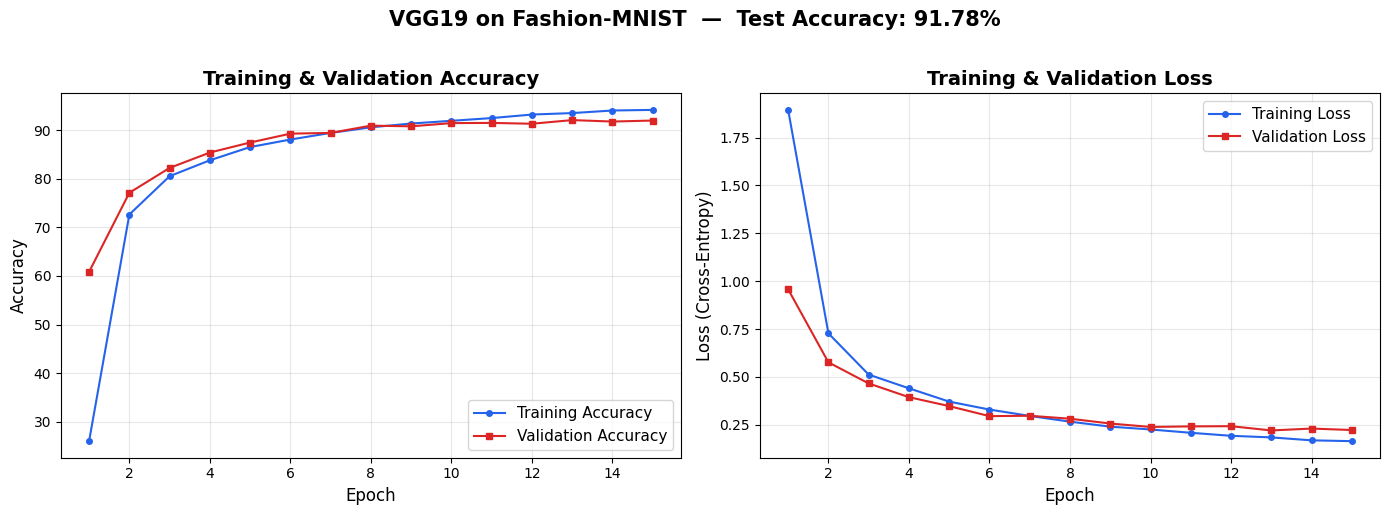

In [33]:
criterion = nn.CrossEntropyLoss()

optimizer_Vgg19 = optim.SGD(
    Model_Vgg19_final.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=5e-4
)

scheduler_Vgg19 = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_Vgg19,
    T_max=50
)

train_losses_vgg19, train_accs_vgg19, val_losses_vgg19, val_accs_vgg19, test_loss_vgg19, test_acc_vgg19 = run_training_pipeline(Model_Vgg19_final, Training_data, Validation_data, Testing_data, criterion, optimizer_Vgg19, scheduler_Vgg19, device, 15)

plot_training_curves(train_losses_vgg19, train_accs_vgg19, val_losses_vgg19, val_accs_vgg19, test_acc_vgg19, 'VGG19')

#Running the ResNEt Model

Saved Best Model
Epoch 1:
Train Loss: 0.4731, Train Acc: 82.86%
Val Loss: 0.3425, Val Acc: 87.64%
Saved Best Model
Epoch 2:
Train Loss: 0.2844, Train Acc: 89.46%
Val Loss: 0.2942, Val Acc: 89.55%
Saved Best Model
Epoch 3:
Train Loss: 0.2267, Train Acc: 91.49%
Val Loss: 0.2663, Val Acc: 90.46%
Epoch 4:
Train Loss: 0.1841, Train Acc: 93.14%
Val Loss: 0.2805, Val Acc: 90.11%
Saved Best Model
Epoch 5:
Train Loss: 0.1557, Train Acc: 94.27%
Val Loss: 0.2800, Val Acc: 90.48%
Saved Best Model
Epoch 6:
Train Loss: 0.1258, Train Acc: 95.42%
Val Loss: 0.2756, Val Acc: 90.78%
Saved Best Model
Epoch 7:
Train Loss: 0.1010, Train Acc: 96.31%
Val Loss: 0.2943, Val Acc: 90.86%
Epoch 8:
Train Loss: 0.0892, Train Acc: 96.69%
Val Loss: 0.3017, Val Acc: 90.66%
Epoch 9:
Train Loss: 0.0720, Train Acc: 97.33%
Val Loss: 0.3430, Val Acc: 90.83%
Epoch 10:
Train Loss: 0.0625, Train Acc: 97.70%
Val Loss: 0.3423, Val Acc: 90.32%
Epoch 11:
Train Loss: 0.0489, Train Acc: 98.23%
Val Loss: 0.3619, Val Acc: 90.76%
Saved

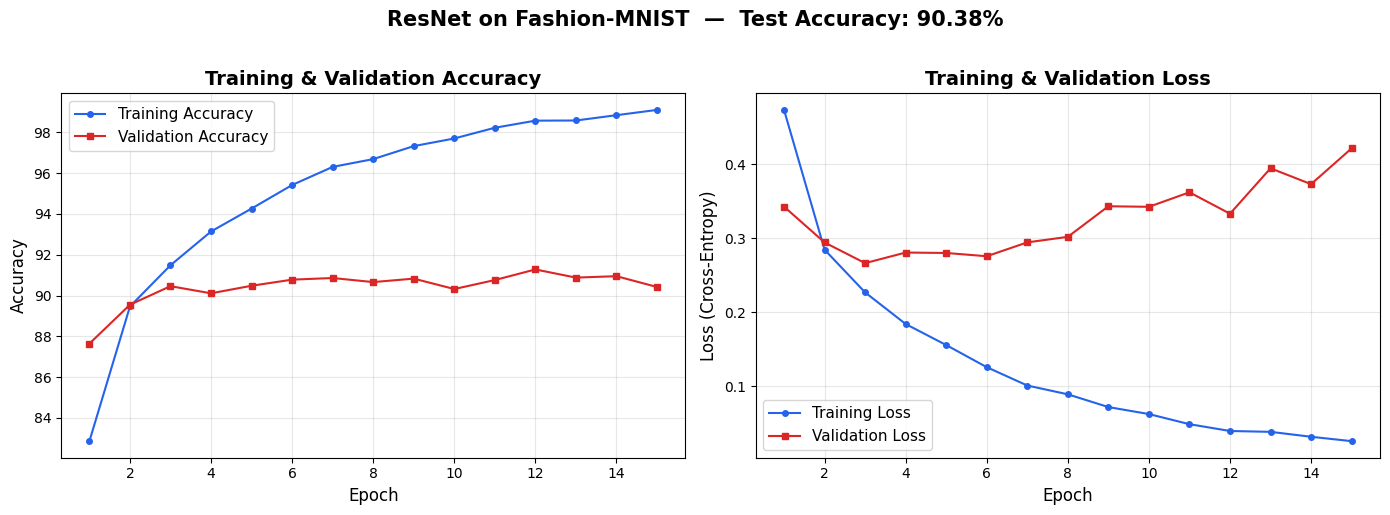

In [34]:
criterion = nn.CrossEntropyLoss()

optimizer_ResNet = optim.SGD(
    Model_ResNet_final.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=5e-4
)

scheduler_ResNet = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_ResNet,
    T_max=50
)

train_losses_resnet, train_accs_resnet, val_losses_resnet, val_accs_resnet, test_loss_resnet, test_acc_resnet = run_training_pipeline(Model_ResNet_final, Training_data, Validation_data, Testing_data, criterion, optimizer_ResNet, scheduler_ResNet, device, 15)

plot_training_curves(train_losses_resnet, train_accs_resnet, val_losses_resnet, val_accs_resnet, test_acc_resnet, 'ResNet')

#Custom CNN Baseline model on Fashion-MNIST using PyTorch


In [35]:
# ─── Custom CNN Architecture ─────────────────────────────────────────
class BaselineCNN(nn.Module):
    """
    Custom CNN for Fashion-MNIST:
    Two conv blocks → flatten → two FC layers.
    Block = Conv → BN → ReLU → Conv → BN → ReLU → MaxPool → Dropout
    """
    def __init__(self, num_classes=10):
        super().__init__()

        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # (B,32,28,28)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # (B,32,28,28)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                               # (B,32,14,14)
            nn.Dropout2d(0.25),
        )

        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (B,64,14,14)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # (B,64,14,14)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                               # (B,64,7,7)
            nn.Dropout2d(0.25),
        )

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Flatten(),                                  # (B, 3136)
            nn.Linear(64 * 7 * 7, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),                   # raw logits
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x

Saved Best Model
Epoch 1:
Train Loss: 0.5036, Train Acc: 81.95%
Val Loss: 0.2977, Val Acc: 89.10%
Saved Best Model
Epoch 2:
Train Loss: 0.3243, Train Acc: 88.21%
Val Loss: 0.2544, Val Acc: 90.76%
Saved Best Model
Epoch 3:
Train Loss: 0.2839, Train Acc: 89.72%
Val Loss: 0.2370, Val Acc: 91.16%
Saved Best Model
Epoch 4:
Train Loss: 0.2572, Train Acc: 90.68%
Val Loss: 0.2239, Val Acc: 91.88%
Saved Best Model
Epoch 5:
Train Loss: 0.2390, Train Acc: 91.33%
Val Loss: 0.2092, Val Acc: 92.42%
Saved Best Model
Epoch 6:
Train Loss: 0.2287, Train Acc: 91.73%
Val Loss: 0.2069, Val Acc: 92.53%
Saved Best Model
Epoch 7:
Train Loss: 0.2165, Train Acc: 92.21%
Val Loss: 0.2014, Val Acc: 92.59%
Saved Best Model
Epoch 8:
Train Loss: 0.2040, Train Acc: 92.65%
Val Loss: 0.1928, Val Acc: 93.12%
Saved Best Model
Epoch 9:
Train Loss: 0.1937, Train Acc: 93.03%
Val Loss: 0.1854, Val Acc: 93.16%
Saved Best Model
Epoch 10:
Train Loss: 0.1833, Train Acc: 93.35%
Val Loss: 0.1870, Val Acc: 93.42%
Epoch 11:
Train Los

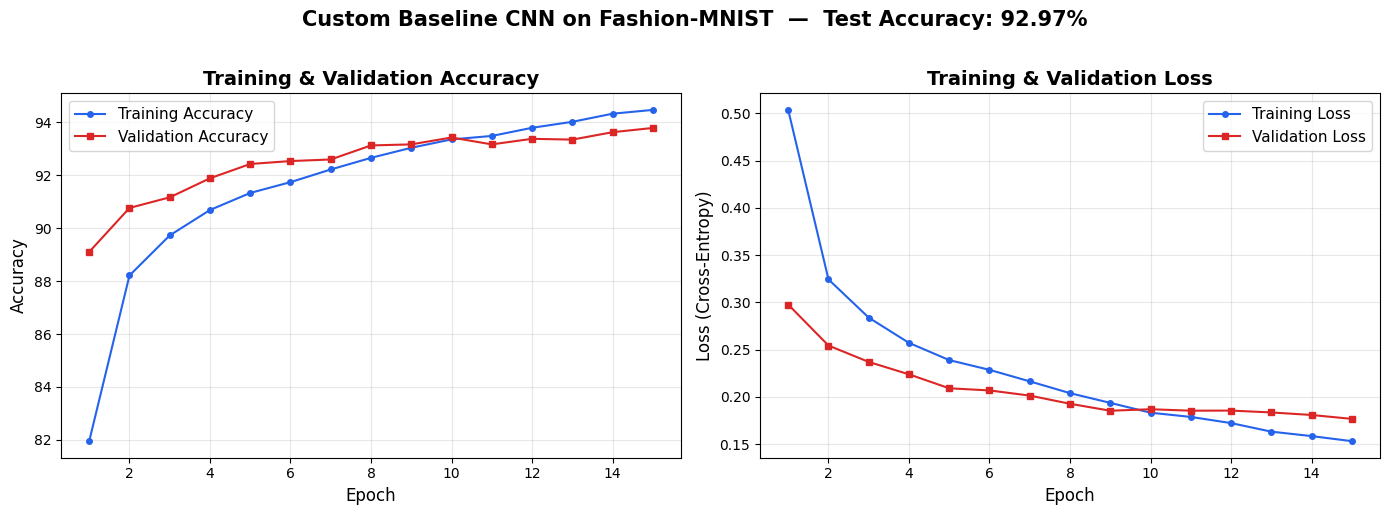

Custom Model Summary:
Final Test Accuracy: 92.97%


In [36]:
# ─── Running Custom CNN Baseline ─────────────────────────────────────
# 1. Instantiate Model
Model_Custom_CNN = BaselineCNN().to(device)

# 2. Setup Loss, Optimizer, and Scheduler (Using same params as VGG/ResNet for comparison)
criterion = nn.CrossEntropyLoss()

optimizer_Custom = optim.SGD(
    Model_Custom_CNN.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=5e-4
)

scheduler_Custom = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_Custom,
    T_max=50
)

# 3. Execute Training Pipeline
# Note: Using 15 epochs to match your VGG/ResNet experiments
train_losses_custom, train_accs_custom, val_losses_custom, val_accs_custom, test_loss_custom, test_acc_custom = run_training_pipeline(
    Model_Custom_CNN,
    Training_data,
    Validation_data,
    Testing_data,
    criterion,
    optimizer_Custom,
    scheduler_Custom,
    device,
    15
)

# 4. Plot results
plot_training_curves(
    train_losses_custom,
    train_accs_custom,
    val_losses_custom,
    val_accs_custom,
    test_acc_custom,
    'Custom Baseline CNN'
)

# 5. Final Report
print(f"Custom Model Summary:")
print(f"Final Test Accuracy: {test_acc_custom:.2f}%")

#Experimenting on the Custom CNN Model ~ for contrained optimization

#Adding Data Augumentation

In [37]:
# Modified transform for Training ONLY
# ─── 1. Updated Transforms with Augmentation ────────────────────────
# Training transform: Includes augmentation to improve robustness
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),         # Randomly flip images horizontally
    transforms.RandomRotation(degrees=10),           # Rotate by +/- 10 degrees
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,)),
])

# Validation/Test transform: No augmentation, only normalization
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,)),
])

# ─── 2. Reload Datasets ──────────────────────────────────────────────
# We reload the base datasets with the different transforms
Train_set_aug = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
Test_set_final = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

# Split the training set again (maintaining the same seed for consistency)
train_set_aug, val_set_aug = random_split(Train_set_aug, [50000, 10000],
                                          generator=torch.Generator().manual_seed(56))

# Define Loaders
Training_data_aug = DataLoader(train_set_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
Validation_data_aug = DataLoader(val_set_aug, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
Testing_data_aug = DataLoader(Test_set_final, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Saved Best Model
Epoch 1:
Train Loss: 0.5919, Train Acc: 78.73%
Val Loss: 0.3740, Val Acc: 86.15%
Saved Best Model
Epoch 2:
Train Loss: 0.4041, Train Acc: 85.16%
Val Loss: 0.3160, Val Acc: 88.23%
Saved Best Model
Epoch 3:
Train Loss: 0.3550, Train Acc: 87.00%
Val Loss: 0.2823, Val Acc: 89.66%
Saved Best Model
Epoch 4:
Train Loss: 0.3318, Train Acc: 87.95%
Val Loss: 0.2601, Val Acc: 90.47%
Saved Best Model
Epoch 5:
Train Loss: 0.3157, Train Acc: 88.49%
Val Loss: 0.2528, Val Acc: 90.74%
Saved Best Model
Epoch 6:
Train Loss: 0.2959, Train Acc: 89.15%
Val Loss: 0.2451, Val Acc: 90.79%
Saved Best Model
Epoch 7:
Train Loss: 0.2876, Train Acc: 89.66%
Val Loss: 0.2399, Val Acc: 91.33%
Saved Best Model
Epoch 8:
Train Loss: 0.2780, Train Acc: 89.99%
Val Loss: 0.2350, Val Acc: 91.45%
Epoch 9:
Train Loss: 0.2730, Train Acc: 90.16%
Val Loss: 0.2357, Val Acc: 91.38%
Saved Best Model
Epoch 10:
Train Loss: 0.2653, Train Acc: 90.38%
Val Loss: 0.2240, Val Acc: 91.86%
Saved Best Model
Epoch 11:
Train Los

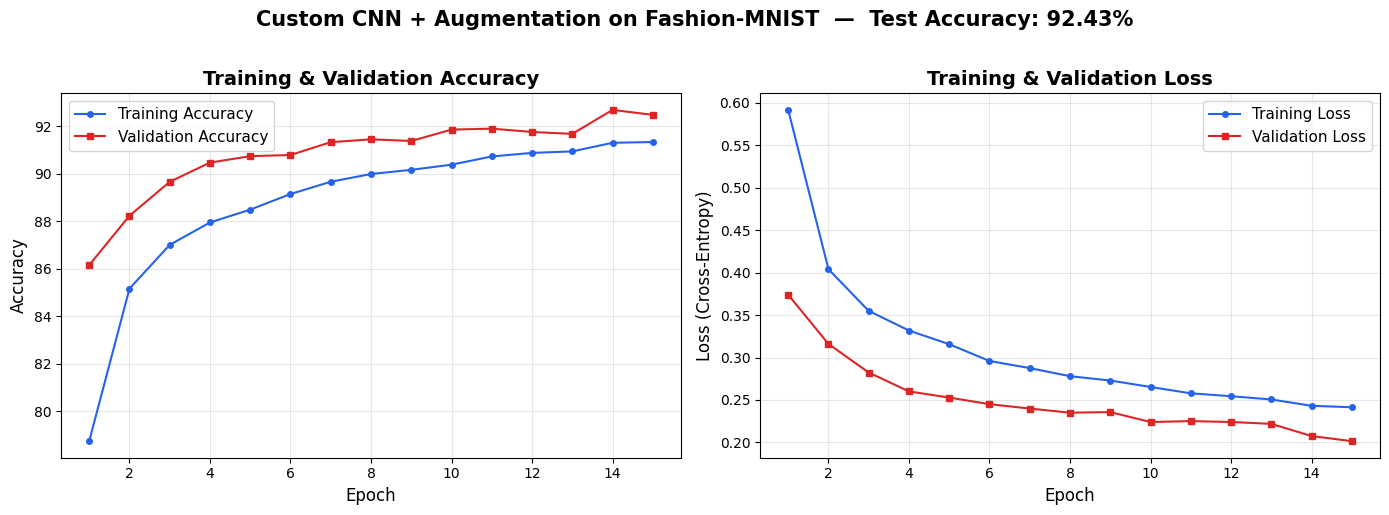

Final Test Accuracy (with Augmentation): 92.43%


In [38]:
# 1. Instantiate a fresh Custom Model
Model_Custom_Aug = BaselineCNN().to(device)

# 2. Setup Optimizer & Scheduler (Keep same as baseline for fair comparison)
optimizer_aug = optim.SGD(Model_Custom_Aug.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler_aug = optim.lr_scheduler.CosineAnnealingLR(optimizer_aug, T_max=50)
criterion = nn.CrossEntropyLoss()

# 3. Run the Training Pipeline
# We use the same number of epochs (15) as the baseline [cite: 22]
train_losses_aug, train_accs_aug, val_losses_aug, val_accs_aug, test_loss_aug, test_acc_aug = run_training_pipeline(
    Model_Custom_Aug,
    Training_data_aug,
    Validation_data_aug,
    Testing_data_aug,
    criterion,
    optimizer_aug,
    scheduler_aug,
    device,
    15
)

# 4. Plot & Compare
plot_training_curves(train_losses_aug, train_accs_aug, val_losses_aug, val_accs_aug, test_acc_aug, 'Custom CNN + Augmentation')

print(f"Final Test Accuracy (with Augmentation): {test_acc_aug:.2f}%")

Saved Best Model
Epoch 1:
Train Loss: 0.6944, Train Acc: 74.44%
Val Loss: 0.4476, Val Acc: 83.05%
Saved Best Model
Epoch 2:
Train Loss: 0.4796, Train Acc: 82.33%
Val Loss: 0.3633, Val Acc: 86.40%
Saved Best Model
Epoch 3:
Train Loss: 0.4227, Train Acc: 84.47%
Val Loss: 0.3539, Val Acc: 86.87%
Saved Best Model
Epoch 4:
Train Loss: 0.3886, Train Acc: 85.86%
Val Loss: 0.3110, Val Acc: 88.68%
Saved Best Model
Epoch 5:
Train Loss: 0.3659, Train Acc: 86.71%
Val Loss: 0.2936, Val Acc: 88.98%
Saved Best Model
Epoch 6:
Train Loss: 0.3454, Train Acc: 87.40%
Val Loss: 0.2745, Val Acc: 89.98%
Epoch 7:
Train Loss: 0.3357, Train Acc: 87.87%
Val Loss: 0.2702, Val Acc: 89.96%
Saved Best Model
Epoch 8:
Train Loss: 0.3237, Train Acc: 88.32%
Val Loss: 0.2620, Val Acc: 90.59%
Saved Best Model
Epoch 9:
Train Loss: 0.3145, Train Acc: 88.59%
Val Loss: 0.2507, Val Acc: 90.63%
Saved Best Model
Epoch 10:
Train Loss: 0.3054, Train Acc: 88.95%
Val Loss: 0.2502, Val Acc: 90.76%
Saved Best Model
Epoch 11:
Train Los

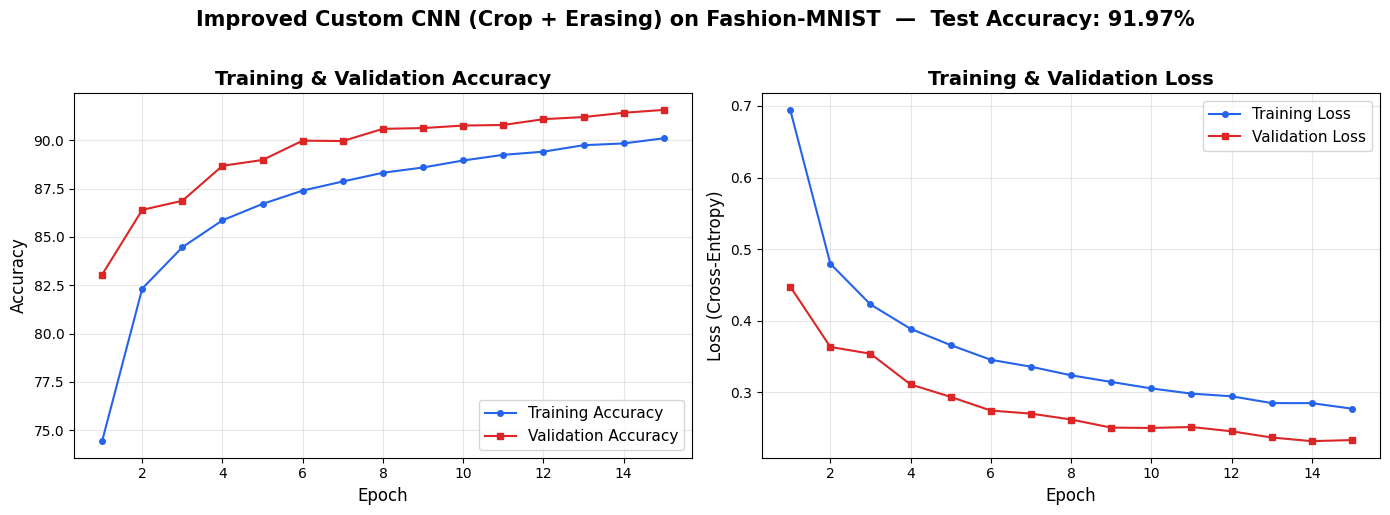

Final Test Accuracy with Improved Augmentation: 91.97%
Saved: improved_aug_custom_cnn.pth


In [39]:
# ─── 1. Improved Augmentation Transforms ────────────────────────────
# Focus: Translation-invariance (Crop) and Occlusion-robustness (Erasing)
train_transform_improved = transforms.Compose([
    transforms.RandomCrop(28, padding=2),           # Adds 2px padding then crops back to 28x28
    transforms.RandomHorizontalFlip(p=0.5),         # Generally safe for Fashion-MNIST
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,)),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3)) # Forces model to find alternative cues
])

# Validation/Test transform remains the same (No augmentation)
test_transform_simple = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,)),
])

# ─── 2. Reload Datasets and DataLoaders ─────────────────────────────
# Re-loading ensures we use the "official train-test splits" as required
Train_set_full = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform_improved)
Test_set_final = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform_simple)

# Use fixed seed 56 for the split to match previous baseline
train_set_imp, val_set_imp = random_split(Train_set_full, [50000, 10000],
                                          generator=torch.Generator().manual_seed(56))

Training_data_imp = DataLoader(train_set_imp, batch_size=128, shuffle=True, num_workers=2)
Validation_data_imp = DataLoader(val_set_imp, batch_size=128, shuffle=False, num_workers=2)
Testing_data_imp = DataLoader(Test_set_final, batch_size=128, shuffle=False, num_workers=2)

# ─── 3. Initialize and Train Improved Model ────────────────────────
# Instantiate a fresh version of your custom CNN
Model_Improved_Aug = BaselineCNN().to(device)

# Using the same optimizer/scheduler as your comparison models for a fair test
optimizer_imp = optim.SGD(Model_Improved_Aug.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler_imp = optim.lr_scheduler.CosineAnnealingLR(optimizer_imp, T_max=50)
criterion = nn.CrossEntropyLoss()

# Run the pipeline (using 15 epochs to match your previous experiments)
train_losses_imp, train_accs_imp, val_losses_imp, val_accs_imp, test_loss_imp, test_acc_imp = run_training_pipeline(
    Model_Improved_Aug,
    Training_data_imp,
    Validation_data_imp,
    Testing_data_imp,
    criterion,
    optimizer_imp,
    scheduler_imp,
    device,
    15
)

# ─── 4. Visualization ───────────────────────────────────────────────
plot_training_curves(
    train_losses_imp, train_accs_imp,
    val_losses_imp, val_accs_imp,
    test_acc_imp,
    'Improved Custom CNN (Crop + Erasing)'
)

print(f"Final Test Accuracy with Improved Augmentation: {test_acc_imp:.2f}%")
# Save the model state dictionary
torch.save(Model_Improved_Aug.state_dict(), 'improved_aug_custom_cnn.pth')
print("Saved: improved_aug_custom_cnn.pth")

#Augumnetation with more epocs


In [40]:
# Modified transform for Training ONLY
# ─── 1. Updated Transforms with Augmentation ────────────────────────
# Training transform: Includes augmentation to improve robustness
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),         # Randomly flip images horizontally
    transforms.RandomRotation(degrees=10),           # Rotate by +/- 10 degrees
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,)),
])

# Validation/Test transform: No augmentation, only normalization
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,)),
])

# ─── 2. Reload Datasets ──────────────────────────────────────────────
# We reload the base datasets with the different transforms
Train_set_aug = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
Test_set_final = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

# Split the training set again (maintaining the same seed for consistency)
train_set_aug, val_set_aug = random_split(Train_set_aug, [50000, 10000],
                                          generator=torch.Generator().manual_seed(56))

# Define Loaders
Training_data_aug = DataLoader(train_set_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
Validation_data_aug = DataLoader(val_set_aug, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
Testing_data_aug = DataLoader(Test_set_final, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Saved Best Model
Epoch 1:
Train Loss: 0.6040, Train Acc: 78.05%
Val Loss: 0.3628, Val Acc: 86.67%
Epoch 2:
Train Loss: 0.4066, Train Acc: 85.15%
Val Loss: 0.3575, Val Acc: 86.42%
Saved Best Model
Epoch 3:
Train Loss: 0.3609, Train Acc: 86.91%
Val Loss: 0.2847, Val Acc: 89.54%
Saved Best Model
Epoch 4:
Train Loss: 0.3354, Train Acc: 87.80%
Val Loss: 0.2668, Val Acc: 90.30%
Epoch 5:
Train Loss: 0.3182, Train Acc: 88.34%
Val Loss: 0.2709, Val Acc: 90.25%
Saved Best Model
Epoch 6:
Train Loss: 0.3032, Train Acc: 89.21%
Val Loss: 0.2442, Val Acc: 90.93%
Epoch 7:
Train Loss: 0.2908, Train Acc: 89.38%
Val Loss: 0.2458, Val Acc: 90.84%
Saved Best Model
Epoch 8:
Train Loss: 0.2832, Train Acc: 89.65%
Val Loss: 0.2326, Val Acc: 91.68%
Epoch 9:
Train Loss: 0.2760, Train Acc: 90.12%
Val Loss: 0.2356, Val Acc: 91.50%
Saved Best Model
Epoch 10:
Train Loss: 0.2653, Train Acc: 90.26%
Val Loss: 0.2254, Val Acc: 91.91%
Saved Best Model
Epoch 11:
Train Loss: 0.2621, Train Acc: 90.58%
Val Loss: 0.2262, Val 

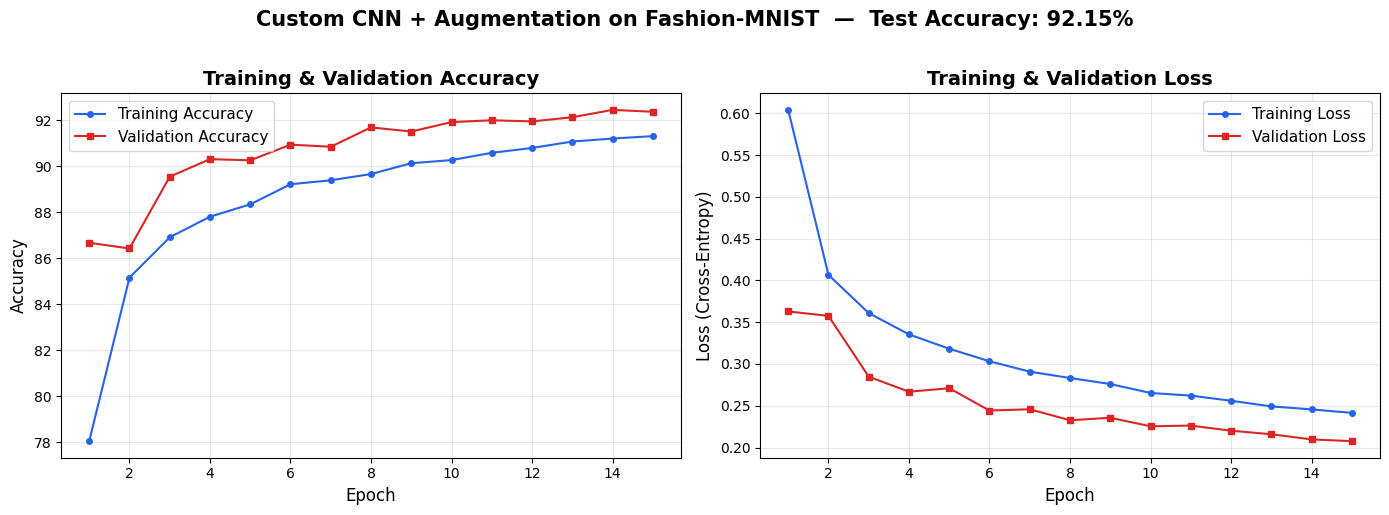

Final Test Accuracy (with Augmentation): 92.15%
Saved Best Model
Epoch 1:
Train Loss: 0.6004, Train Acc: 78.16%
Val Loss: 0.3757, Val Acc: 86.55%
Saved Best Model
Epoch 2:
Train Loss: 0.4091, Train Acc: 85.01%
Val Loss: 0.3182, Val Acc: 88.12%
Saved Best Model
Epoch 3:
Train Loss: 0.3595, Train Acc: 87.05%
Val Loss: 0.2880, Val Acc: 89.33%
Saved Best Model
Epoch 4:
Train Loss: 0.3310, Train Acc: 87.96%
Val Loss: 0.2741, Val Acc: 89.90%
Saved Best Model
Epoch 5:
Train Loss: 0.3138, Train Acc: 88.52%
Val Loss: 0.2561, Val Acc: 90.68%
Saved Best Model
Epoch 6:
Train Loss: 0.3034, Train Acc: 89.08%
Val Loss: 0.2529, Val Acc: 90.77%
Saved Best Model
Epoch 7:
Train Loss: 0.2900, Train Acc: 89.62%
Val Loss: 0.2405, Val Acc: 91.50%
Epoch 8:
Train Loss: 0.2824, Train Acc: 89.70%
Val Loss: 0.2438, Val Acc: 91.11%
Saved Best Model
Epoch 9:
Train Loss: 0.2722, Train Acc: 90.16%
Val Loss: 0.2287, Val Acc: 91.86%
Epoch 10:
Train Loss: 0.2686, Train Acc: 90.26%
Val Loss: 0.2229, Val Acc: 91.76%
Epoch

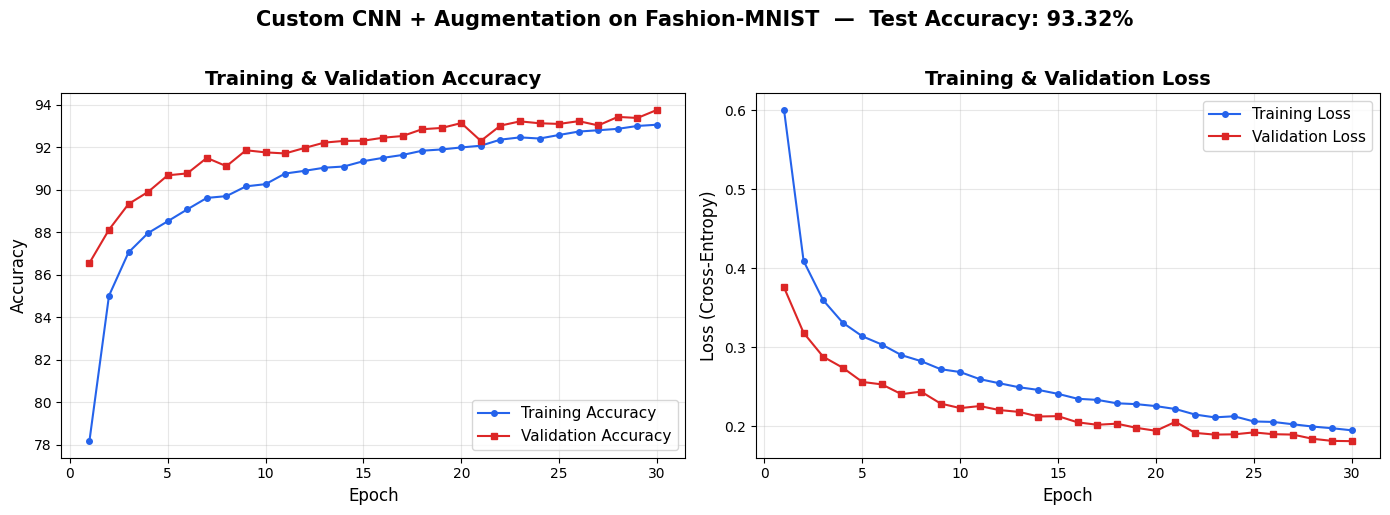

Final Test Accuracy (with Augmentation 30 Epochs): 93.32%
Saved: improved_aug_custom_cnn_moreepochs.pth


In [41]:
# 1. Instantiate a fresh Custom Model
Model_Custom_Aug = BaselineCNN().to(device)

# 2. Setup Optimizer & Scheduler (Keep same as baseline for fair comparison)
optimizer_aug = optim.SGD(Model_Custom_Aug.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler_aug = optim.lr_scheduler.CosineAnnealingLR(optimizer_aug, T_max=50)
criterion = nn.CrossEntropyLoss()

# 3. Run the Training Pipeline
# We use the same number of epochs (15) as the baseline [cite: 22]
train_losses_aug, train_accs_aug, val_losses_aug, val_accs_aug, test_loss_aug, test_acc_aug = run_training_pipeline(
    Model_Custom_Aug,
    Training_data_aug,
    Validation_data_aug,
    Testing_data_aug,
    criterion,
    optimizer_aug,
    scheduler_aug,
    device,
    15
)

# 4. Plot & Compare
plot_training_curves(train_losses_aug, train_accs_aug, val_losses_aug, val_accs_aug, test_acc_aug, 'Custom CNN + Augmentation')

print(f"Final Test Accuracy (with Augmentation): {test_acc_aug:.2f}%")# 1. Instantiate a fresh Custom Model
Model_Custom_Aug = BaselineCNN().to(device)

# 2. Setup Optimizer & Scheduler (Keep same as baseline for fair comparison)
optimizer_aug = optim.SGD(Model_Custom_Aug.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler_aug = optim.lr_scheduler.CosineAnnealingLR(optimizer_aug, T_max=50)
criterion = nn.CrossEntropyLoss()

# 3. Run the Training Pipeline
# We use the same number of epochs (15) as the baseline [cite: 22]
train_losses_aug, train_accs_aug, val_losses_aug, val_accs_aug, test_loss_aug, test_acc_aug = run_training_pipeline(
    Model_Custom_Aug,
    Training_data_aug,
    Validation_data_aug,
    Testing_data_aug,
    criterion,
    optimizer_aug,
    scheduler_aug,
    device,
    30
)

# 4. Plot & Compare
plot_training_curves(train_losses_aug, train_accs_aug, val_losses_aug, val_accs_aug, test_acc_aug, 'Custom CNN + Augmentation')

print(f"Final Test Accuracy (with Augmentation 30 Epochs): {test_acc_aug:.2f}%")

torch.save(Model_Improved_Aug.state_dict(), 'improved_aug_custom_cnn_moreepochs.pth')
print("Saved: improved_aug_custom_cnn_moreepochs.pth")

In [42]:
torch.save(Model_Custom_Aug.state_dict(), 'improved_aug_custom_cnn_moreepochs.pth')
print("Saved: improved_aug_custom_cnn_moreepochs.pth")

Saved: improved_aug_custom_cnn_moreepochs.pth


Faliure CAse Analysis.

In [43]:
import torch.nn.functional as F
import cv2

In [44]:
# 2. Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaselineCNN().to(device)
model.load_state_dict(torch.load('improved_aug_custom_cnn_moreepochs.pth', map_location=device))
model.eval()

# 3. Load Test Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

CLASS_NAMES = testset.classes

In [45]:
# ─── 1. Failure Detection & Uncertainty Estimation ────────────────────────────
def get_failure_analysis(model, dataloader, device):
    model.eval()
    failures = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Get probabilities and predictions
            probs = F.softmax(outputs, dim=1)
            conf, preds = torch.max(probs, 1)

            # Calculate Entropy (Uncertainty Measure)
            # Higher entropy means the model is "confused" between classes
            entropy = -torch.sum(probs * torch.log(probs + 1e-8), dim=1)

            # Find misclassifications
            incorrect_mask = (preds != labels)

            if incorrect_mask.any():
                # Store data for incorrect predictions
                fail_imgs = images[incorrect_mask].cpu()
                fail_labels = labels[incorrect_mask].cpu()
                fail_preds = preds[incorrect_mask].cpu()
                fail_entropy = entropy[incorrect_mask].cpu()
                fail_conf = conf[incorrect_mask].cpu()

                for i in range(len(fail_imgs)):
                    failures.append({
                        'image': fail_imgs[i],
                        'true_label': fail_labels[i].item(),
                        'pred_label': fail_preds[i].item(),
                        'entropy': fail_entropy[i].item(),
                        'confidence': fail_conf[i].item()
                    })

    # Sort failures by Entropy (High entropy = "I don't know", Low entropy = "Confident but Wrong")
    failures.sort(key=lambda x: x['entropy'], reverse=True)
    return failures

In [46]:
# ─── 2. Grad-CAM Implementation for BaselineCNN ───────────────────────────────
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook into the target layer
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, class_idx):
        # Forward pass
        self.model.zero_grad()
        output = self.model(input_tensor.unsqueeze(0))

        # Backward pass for the specific class
        score = output[0, class_idx]
        score.backward()

        # 1. Global Average Pooling of gradients
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # 2. Weighted sum of activations
        cam = torch.sum(weights * self.activations, dim=1).squeeze()

        # 3. Apply ReLU (we only care about positive influence)
        cam = F.relu(cam)

        # 4. Normalize to 0-1
        if cam.max() > 0:
            cam = (cam - cam.min()) / (cam.max() - cam.min())
        else:
            cam = cam # Avoid div by zero if cam is all zeros

        return cam.detach().cpu().numpy()



In [47]:
# ─── 3. Visualization Function ───────────────────────────────────────────────
def visualize_failures(model, failures, class_names, num_show=20):
    # Hook Grad-CAM to the last conv layer of block2
    # In your BaselineCNN, block2 is: Conv -> BN -> ReLU -> Conv (idx 3) -> ...
    target_layer = model.block2[3]
    gcam = GradCAM(model, target_layer)

    plt.figure(figsize=(15, 4 * num_show))

    # We will verify the device again just in case
    device = next(model.parameters()).device

    for i in range(min(num_show, len(failures))):
        case = failures[i]
        img_tensor = case['image'].to(device)

        # Generate Heatmap for the PREDICTED (Wrong) Class
        heatmap = gcam.generate(img_tensor, case['pred_label'])

        # Prepare image for plotting (from 1x28x28 tensor to 28x28 numpy)
        img_np = img_tensor.squeeze().cpu().numpy()

        # Resize heatmap to match image size
        heatmap_resized = cv2.resize(heatmap, (28, 28))
        heatmap_resized = np.uint8(255 * heatmap_resized)
        heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

        # Create overlay
        img_bgr = cv2.cvtColor(np.uint8(255 * img_np), cv2.COLOR_GRAY2BGR)
        overlay = cv2.addWeighted(img_bgr, 0.6, heatmap_colored, 0.4, 0)

        # Plot Original
        plt.subplot(num_show, 3, i*3 + 1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"True: {class_names[case['true_label']]}")
        plt.axis('off')

        # Plot Heatmap Overlay
        plt.subplot(num_show, 3, i*3 + 2)
        plt.imshow(overlay)
        plt.title(f"Pred: {class_names[case['pred_label']]}\n")
        plt.axis('off')

        # Plot Failure Stats
        plt.subplot(num_show, 3, i*3 + 3)
        plt.text(0.1, 0.6, f"Entropy (Uncertainty): {case['entropy']:.4f}", fontsize=12)
        plt.text(0.1, 0.4, f"Confidence: {case['confidence']*100:.2f}%", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Detecting failure cases...
Found 668 incorrect predictions out of 10,000 test images.

--- Top High Uncertainty Failures (Model was guessing) ---


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


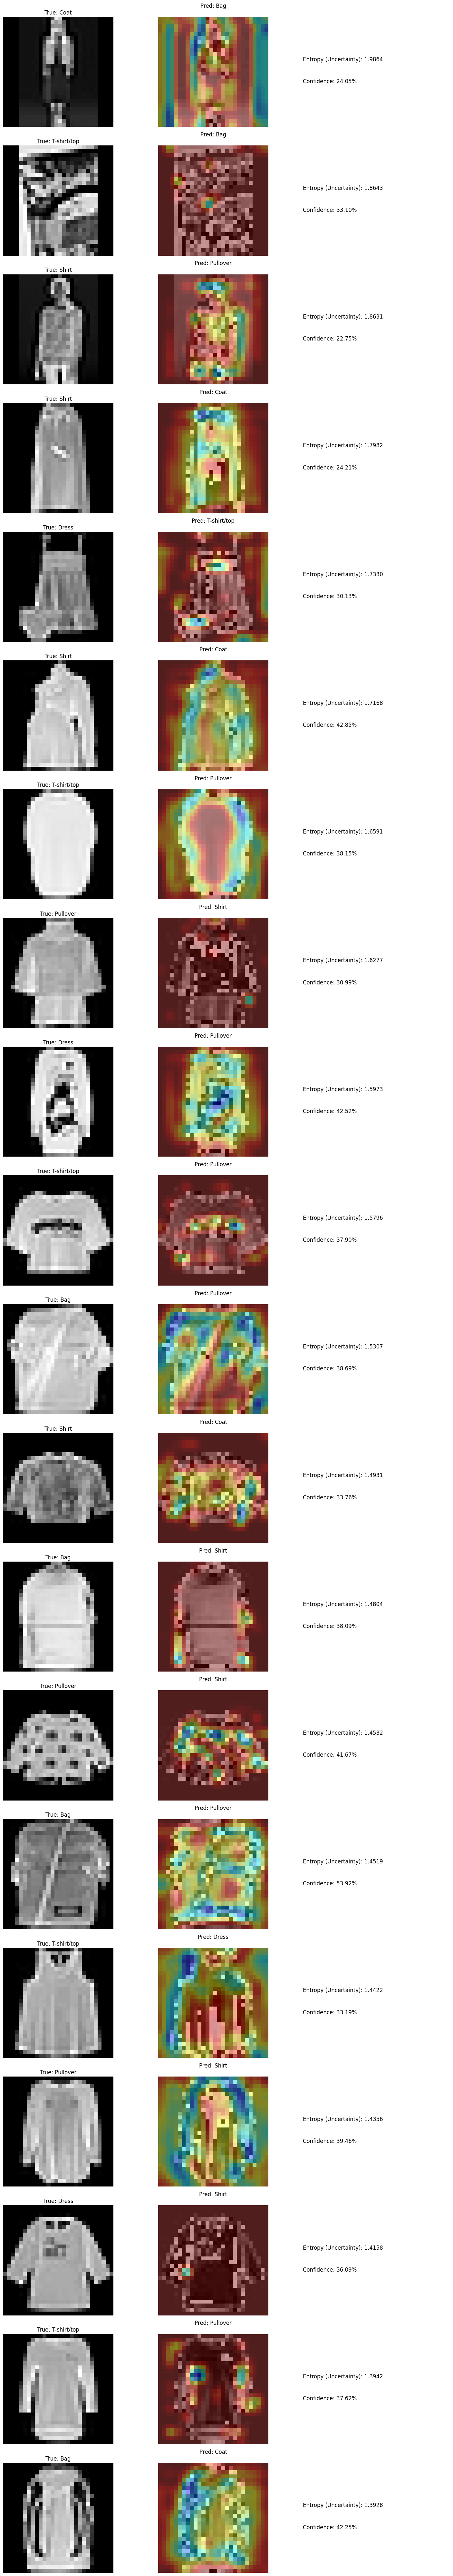


--- Top Confident Failures (Model was sure but wrong) ---


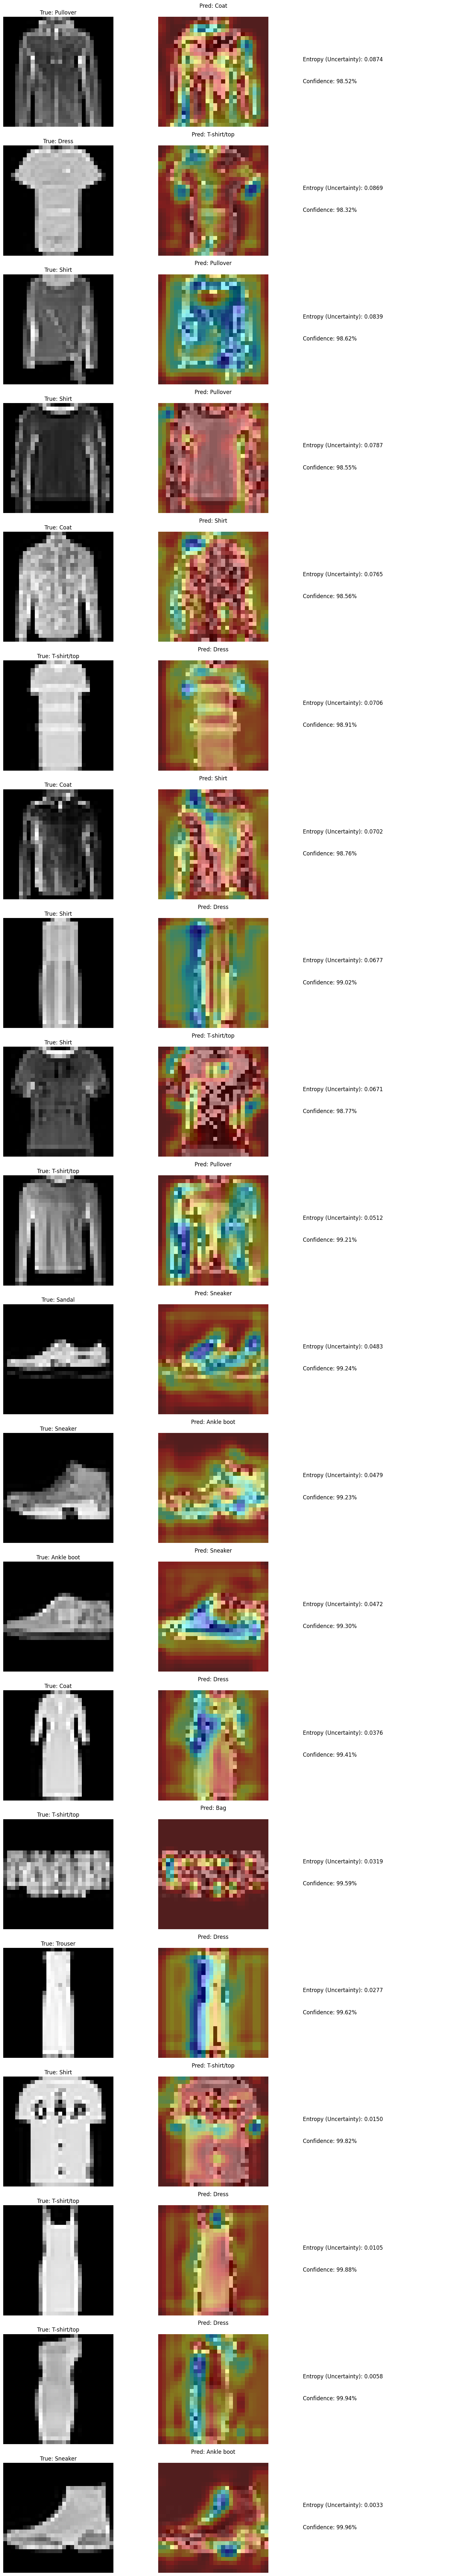

In [48]:
# ─── 4. Run Analysis ─────────────────────────────────────────────────────────

# 1. Get failures
# Note: Ensure 'model' and 'Testing_data' are defined from your previous cells
print("Detecting failure cases...")
failures = get_failure_analysis(model, Testing_data, device)
print(f"Found {len(failures)} incorrect predictions out of 10,000 test images.")

# 2. Visualize the "Most Confused" failures (Highest Entropy)
print("\n--- Top High Uncertainty Failures (Model was guessing) ---")
visualize_failures(model, failures[:20], CLASS_NAMES)

# 3. Visualize "Confident but Wrong" failures (Lowest Entropy)
# These are dangerous failures where the model is sure but wrong
print("\n--- Top Confident Failures (Model was sure but wrong) ---")
visualize_failures(model, failures[-20:], CLASS_NAMES)

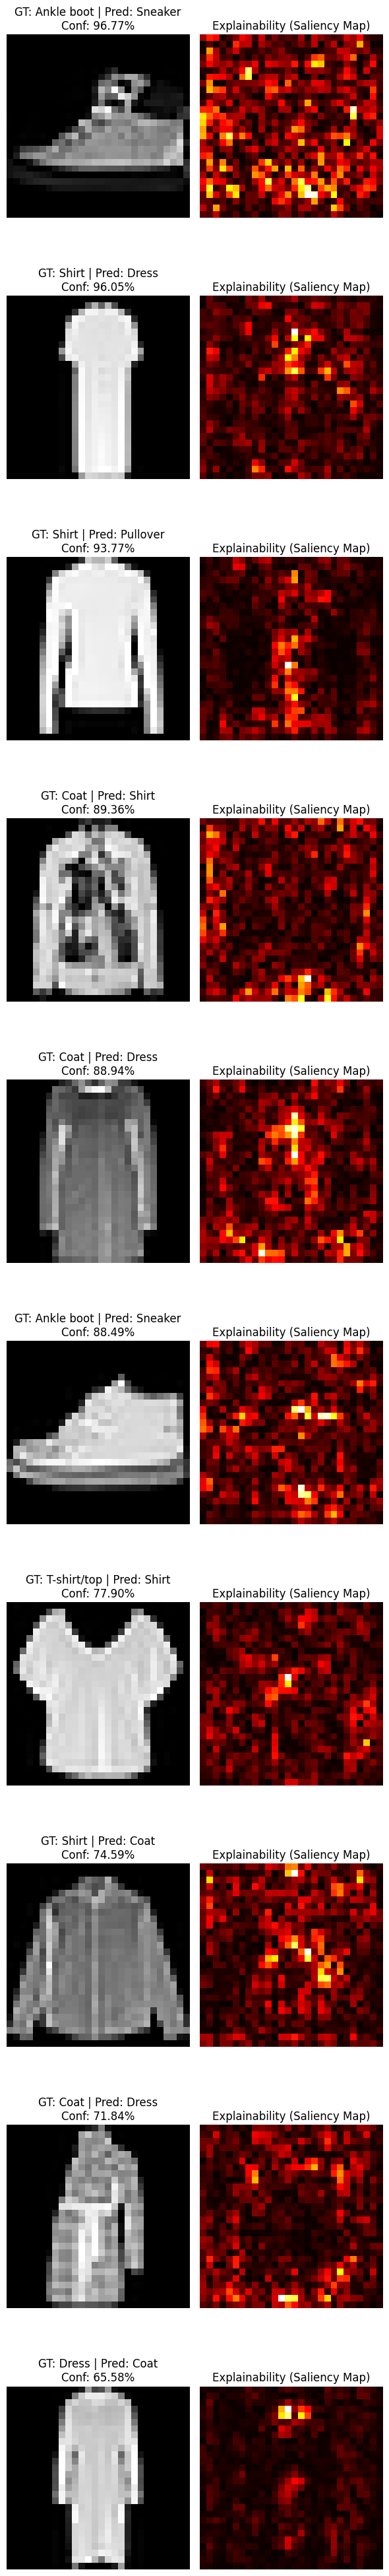

In [49]:
def Saliency_mapping(model, loader, num_cases=10):
    failures = []

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad_() # Required for Saliency Map

        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        conf, preds = torch.max(probs, 1)

        if preds[0] != labels[0]:
            # Generate Saliency Map (Explainability)
            score = outputs[0, preds[0]]
            score.backward()
            saliency, _ = torch.max(torch.abs(images.grad.data.abs()), dim=1)

            failures.append({
                'image': images.detach().cpu().squeeze(),
                'saliency': saliency.cpu().squeeze(),
                'true': CLASS_NAMES[labels[0]],
                'pred': CLASS_NAMES[preds[0]],
                'conf': conf.item() * 100
            })

        if len(failures) >= 20: break # Collect a small pool to pick the most "confident" ones

    # Sort by confidence score (as required by assignment)
    failures = sorted(failures, key=lambda x: x['conf'], reverse=True)[:num_cases]

    # Plotting the Failure Cases
    fig, axes = plt.subplots(num_cases, 2, figsize=(6, num_cases * 4))
    for i, f in enumerate(failures):
        # Original Image
        axes[i, 0].imshow(f['image'], cmap='gray')
        axes[i, 0].set_title(f"GT: {f['true']} | Pred: {f['pred']}\nConf: {f['conf']:.2f}%")
        axes[i, 0].axis('off')

        # Saliency Map
        axes[i, 1].imshow(f['saliency'], cmap='hot')
        axes[i, 1].set_title(f"Explainability (Saliency Map)")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

Saliency_mapping(model, testloader)